
<a id='numerical-linear-algebra'></a>

# Numerical Linear Algebra and Factorizations

## Contents

- [Numerical Linear Algebra and Factorizations](#Numerical-Linear-Algebra-and-Factorizations)  
  - [Overview](#Overview)  
  - [Simple Examples](#Simple-Examples)  
  - [Factorizations](#Factorizations)  
  - [Continuous Time Markov Chains (CTMC)](#Continuous-Time-Markov-Chains-%28CTMC%29)  
  - [Banded Matrices](#Banded-Matrices)  
  - [Implementing Low Level Kernels](#Implementing-Low-Level-Kernels)  
  - [Exercises](#Exercises)  

> You cannot learn too much linear algebra. – Benedict Gross

## Overview

In particular, we will examine the structure of matrices and linear operators (e.g., dense, sparse, symmetric, tridiagonal, banded) and
discuss how it can be exploited to radically increase the performance of solving the problems.

We build on [linear algebra](linear_algebra.html), [orthogonal projections](orth_proj.html), and [finite Markov Chains](finite_markov.html).

The methods in this section are called direct methods, and they are qualitatively similar to performing Gaussian elimination to factor matrices and solve systems.  In [iterative methods and sparsity](iterative_methods_sparsity.html) we examine a different approach with iterative algorithms, and generalized the matrices as linear operators.y

The list of specialized packages for these tasks is enormous and growing, but some of the important organizations to
look at are [JuliaMatrices](https://github.com/JuliaMatrices) , [JuliaSparse](https://github.com/JuliaSparse), and [JuliaMath](https://github.com/JuliaMath)

**NOTE** This lecture explores techniques linear algebra, with an emphasis on large systems.  You may wish to review multiple-dispatch and generic programming in  introduction to types, and consider further study on [generic programming](more_julia/generic_programming.html).

### Setup

In [1]:
using LinearAlgebra, Statistics, BenchmarkTools, SparseArrays, Random
Random.seed!(42);  # seed random numbers for reproducibility

### Applications

Some key questions to motivate the lecture.  Is the following a computationally expensive operation as the size of the matrix increases?

- Multiplying two matrices?  It depends.  Multiplying 2 diagonals is trivial.  
- Solving a linear system of equations?  It depends.  If the matrix is the identity, the solution is the vector itself.  
- Finding the eigenvalues of a matrix?  It depends.  The eigenvalues of a triangular matrix are the diagonal.  


With that in mind, in this section lecture, we consider variations on three classic problems.

First is the solution to

$$
A x = b
$$

for a square $ A $ where we will maintain throughout there is a unique solution.

On paper, since the [Invertible Matrix Theorem](https://en.wikipedia.org/wiki/Invertible_matrix#The_invertible_matrix_theorem) tells us a unique solution is
equivalent to $ A $ being invertible, we often write the solution as

$$
x = A^{-1} b
$$

Second, in the case of a rectangular matrix, $ A $ we consider the [linear least-squares](https://en.wikipedia.org/wiki/Linear_least_squares) solution
to

$$
\min_x ||Ax -b||^2
$$

From theory, we know that $ A $ has linearly independent columns that the solution is the [normal equations](https://en.wikipedia.org/wiki/Linear_least_squares#Derivation_of_the_normal_equations)

$$
x = (A'A)^{-1}A'b
$$

And finally, consider the eigenvalue problem of finding $ x $ and $ \lambda $ such that

$$
A x = \lambda x
$$

For the eigenvalue problems.  Keep in mind that that you do not always require all of the $ \lambda $, and sometimes the largest (or smallest) would be enough.  For example, calculating the spectral radius only requires the maximum eigenvalue in absolute value.

The theme of this lecture, and numerical linear algebra in general, comes down to three principles:

1. **identify structure** (e.g. [symmetric, sparse, diagonal,etc.](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/index.html#Special-matrices-1)) of $ A $ in order to use **specialized algorithms**  
1. **do not lose structure** by applying the wrong linear algebra operations at the wrong times (e.g. sparse matrix becoming dense)  
1. understand the **computational complexity** of each algorithm  

### Computational Complexity

As the goal of this section is to move towards numerical linear algebra of large systems, we need to understand how well algorithms scale with size.  This notion is called [computational complexity](https://en.wikipedia.org/wiki/Computational_complexity).

While this notion of complexity can work at various levels such as the number of [significant digits](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Arithmetic_functions) for basic mathematical operations, the amount of memory and storage required, or the amount of time) - but we will typically focus on the time-complexity.

For time-complexity, the `N` is usually the dimensionality of the problem, although occasionally the key will be the number of non-zeros in the matrix or width of bands.  For our applications, time-complexity is best thought of as the number of floating point operations (e.g. add, multiply, etc.) required.

Complexity of algorithms is typically written in [Big O](https://en.wikipedia.org/wiki/Big_O_notation) notation which provides bounds on the scaling.

Formally, we can write this as $ f(N) = O(g(N)) \text{ as} N \to \infty $ wher the interpretation is that there exists some constants $ M, N_0 $ such that

$$
f(N) \leq M g(N), \text{ for } N > N_0
$$

For example, the complexity of finding an LU Decomposition of a dense matrix is $ O(N^3) $ which should be read as there being a constant where
eventually the number of floating point operations required decompose a matrix of size $ N\times N $ grows cubically.

Keep in mind that these are asymptotic results intended to understanding the scaling of the problem, and the constant can matter for a given
fixed size.

For example, the number of operations required for an [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition#Algorithms) of a dense $ N \times N $ matrix $ 2/3 N^3 $, ignoring the $ N^2 $ and lower terms.  However, sparse matrix algorithms instead scale with the number of non-zeros in the matrix instead.

### Rules of Computational Complexity

When combining algorithms, you will sometimes need to think through how [combining algorithms](https://en.wikipedia.org/wiki/Big_O_notation#Properties) changes complexity.  For example, if you do,

1. an $ O(N^3) $ operation $ P $ times, then it simply changes the constant and remains $ O(N^3) $  
1. one $ O(N^3) $ operation and another $ O(N^2) $ one, then you take the max, which does not change the scale $ O(N^3) $  
1. a repetition of a $ O(N) $ operation that itself uses an $ O(N) $ one, you take the product, and the complexity becomes $ O(N^2) $  


With this, there is a word of caution: dense matrix-multiplication is an [expensive operation](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra) for unstructured matrices, and the basic version is $ O(N^3) $.

Of course, modern libraries use highly turned and [careful algorithms](https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm) to multiply matrices and exploit the computer architecture, memory cache, etc., but this simply lowers the constant of proportionality and they remain $ O(N^3) $.

A consequence is that, since many algorithms require matrix-matrix multiplication, it means that it is usually not possible to go below that order without further matrix structure.

That is, changing the constant of proportionality for a given size can help, but in order to achieve higher scaling you need to identify matrix structure and ensure your operations do not lose it.

### Losing Structure

As a first example of a structured matrix, consider a [sparse arrays](https://docs.julialang.org/en/v1/stdlib/SparseArrays/index.html)

In [2]:
A = sprand(10, 10, 0.45)  # random 10x10, 45% filled with non-zeros

@show nnz(A)  # counts the number of non-zeros
invA = sparse(inv(Array(A)))  # Julia won't even invert sparse directly
@show nnz(invA);

nnz(A) = 47
nnz(invA) = 100


This increase from 45 to 100 percent dense demonstrates that significant sparsity can be lost when calculating an inverse.

The results can be even more extreme.  Consider a tridiagonal matrix of size $ N \times N $
that might come out of a Markov Chain or discretization  of a diffusion process,

In [3]:
N = 5
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])

5×5 Tridiagonal{Float64,Array{Float64,1}}:
 0.8  0.2   ⋅    ⋅    ⋅ 
 0.1  0.8  0.1   ⋅    ⋅ 
  ⋅   0.1  0.8  0.1   ⋅ 
  ⋅    ⋅   0.1  0.8  0.1
  ⋅    ⋅    ⋅   0.2  0.8

The number of non-zeros here is approximately $ 3 N $, linear, which scales well for huge matrices into the millions or billions

But consider the inverse

In [4]:
inv(A)

5×5 Array{Float64,2}:
  1.29099      -0.327957     0.0416667  -0.00537634   0.000672043
 -0.163978      1.31183     -0.166667    0.0215054   -0.00268817 
  0.0208333    -0.166667     1.29167    -0.166667     0.0208333  
 -0.00268817    0.0215054   -0.166667    1.31183     -0.163978   
  0.000672043  -0.00537634   0.0416667  -0.327957     1.29099    

Now, the matrix is fully dense and scales $ N^2 $

This also applies to the $ A' A $ operation in the normal equations of LLS.

In [5]:
A = sprand(20, 21, 0.3)
@show nnz(A)/20^2
@show nnz(A'*A)/21^2;

nnz(A) / 20 ^ 2 = 0.2825
nnz(A' * A) / 21 ^ 2 = 0.800453514739229


While there is some variation based on the randoms chosen, we see that a 30 percent dense matrix becomes almost full dense
after the product is taken.

**Sparsity/Structure is not just for storage**:  While we have been emphasizing counting the non-zeros as a heuristic, the primary reason to maintain structure
and sparsity is not for using less memory to store the matrices.

Size can sometimes become important (e.g. a 1 million by 1 million tridiagonal matrix needs to store 3 million numbers (i.e, about 6MB of memory), where a dense one requires 1 trillion (i.e., about 1TB of memory).

But, as we will see, the main purpose of considering sparsity and matrix structure is that it enables specialized algorithms which typically
have a lower-computational order than unstructured dense, or even an unstructured sparse operations.

First, create convenient functions for benchmarking which displays the type

In [6]:
using BenchmarkTools
function benchmark_solve(A, b)
    println("A\\b for typeof(A) = $(string(typeof(A)))")
    @btime $A \ $b
end

benchmark_solve (generic function with 1 method)

Then, take away structure to see the impact on performance,

In [7]:
N = 1000
b = rand(N)
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
A_sparse = sparse(A)
A_dense = Array(A)

# benchmark solution to system A x = b and A * B
benchmark_solve(A, b)
benchmark_solve(A_sparse, b)
benchmark_solve(A_dense, b);

A\b for typeof(A) = Tridiagonal{Float64,Array{Float64,1}}
  20.600 μs (9 allocations: 47.75 KiB)
A\b for typeof(A) = SparseMatrixCSC{Float64,Int64}
  535.700 μs (69 allocations: 1.06 MiB)
A\b for typeof(A) = Array{Float64,2}
  45.582 ms (5 allocations: 7.65 MiB)


This example shows what is at stake:  using a structured tridiagonal may be 10-20x faster than using a sparse matrix which is 100x faster then
using a dense matrix.

In fact, the difference becomes more extreme as the matrices grow.  Solving a tridiagonal system is an $ O(N) $ while that of a dense matrix without any structure is $ O(N^3) $.  The complexity of a sparse solution is more complicated, but roughly scales by $ O(nnz(N)) $, i.e. the number of nonzeros.

## Simple Examples

### Inverting Matrices

To begin, consider a simple linear system of a dense matrix

In [8]:
N = 4
A = rand(N,N)
b = rand(N)

4-element Array{Float64,1}:
 0.5125312396664188
 0.6828679275339775
 0.3454193757566306
 0.8706954827549864

On paper, we to solve for $ A x = b $ by inverting the matrix,

In [9]:
x = inv(A) * b

4-element Array{Float64,1}:
 -0.8230616861035331
  1.1336956414831805
 -1.642325023331038 
  2.2104913647288558

As we will see, inverting matrices should be used for theory, not for code.  The classic advice that you should [never invert a matrix](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix) may be [slightly exaggerated](https://arxiv.org/abs/1201.6035), but is generally good advice.  In fact, the methods used by libraries to invert matrices typically calculate the same factorizations used for computing a system of equations.

To summarize the wisdom: solving a system by inverting a matrix is always a little slower, potentially less accurate, and will often lose crucial sparsity.

### Triangular Matrices and Back/Forward Substitution

To begin, consider solving a system with an `UpperTriangular` matrix,

In [10]:
b = [1.0, 2.0, 3.0]
U = UpperTriangular([1.0 2.0 3.0; 0.0 5.0 6.0; 0.0 0.0 9.0])

3×3 UpperTriangular{Float64,Array{Float64,2}}:
 1.0  2.0  3.0
  ⋅   5.0  6.0
  ⋅    ⋅   9.0

This system is especially easy to solve using [back-substitution](https://en.wikipedia.org/wiki/Triangular_matrix#Forward_and_back_substitution).  In particular, $ x_3 = b_3 / U_{33}, x_2 = (b_2 - x_3 U_{23})/U_{22} $, etc.

In [11]:
U \ b

3-element Array{Float64,1}:
 0.0               
 0.0               
 0.3333333333333333

A `LowerTriangular` has similar properties and can be solved with forward-substitution.  For these matrices, no further matrix factorization is needed.

The computational order of back-substitution and forward-substitution is $ O(N^2) $ for dense matrices.

### A Warning on Matrix Multiplication

Why we write matrix multiplications in our algebra with abandon, in practice the operation scales very poorly without any matrix structure.

Matrix multiplication is so important to modern computers that the constant of scaling in front of the scaling has been radically reduced
when using a proper package, but the order is still $ O(N^3) $ in practice.

Sparse matrix multiplication, on the other hand, is $ O(N M_A M_B) $ where $ M_A $ are the number of nonzeros per row of $ A $ and $ B $ are the number of non-zeros per column of $ B $.

By the rules of computational order, that means any algorithm this means that any algorithm requiring a matrix multiplication of dense matrices requires at least $ O(N^3) $ operation.

The other important question is what is the structure of the resulting matrix. As always, we want to avoid losing

For example, multiplying an upper triangular by a lower triangular

In [12]:
N = 5
U = UpperTriangular(rand(N,N))

5×5 UpperTriangular{Float64,Array{Float64,2}}:
 0.409653  0.0195282  0.87974     0.552949  0.252486
  ⋅        0.436677   0.662624    0.736553  0.224344
  ⋅         ⋅         0.00653798  0.649019  0.134132
  ⋅         ⋅          ⋅          0.168964  0.834989
  ⋅         ⋅          ⋅           ⋅        0.708384

In [13]:
L = U'

5×5 Adjoint{Float64,UpperTriangular{Float64,Array{Float64,2}}}:
 0.409653   0.0       0.0         0.0       0.0     
 0.0195282  0.436677  0.0         0.0       0.0     
 0.87974    0.662624  0.00653798  0.0       0.0     
 0.552949   0.736553  0.649019    0.168964  0.0     
 0.252486   0.224344  0.134132    0.834989  0.708384

But the multiplication is fully dense (e.g. think of a cholesky multiplied by itself to produce a covariance matrix)

In [14]:
L * U

5×5 Array{Float64,2}:
 0.167816    0.00799978  0.360388  0.226517  0.103432
 0.00799978  0.191068    0.306533  0.332434  0.102897
 0.360388    0.306533    1.21306   0.978752  0.371655
 0.226517    0.332434    0.978752  1.29804   0.532991
 0.103432    0.102897    0.371655  0.532991  1.33109 

On the other hand, a tridiagonal times a diagonal is still a tridiagonal and $ O(N^2) $

In [15]:
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
D = Diagonal(rand(N))
D * A

5×5 Tridiagonal{Float64,Array{Float64,1}}:
 0.561922   0.14048     ⋅          ⋅          ⋅      
 0.0568224  0.454579   0.0568224   ⋅          ⋅      
  ⋅         0.0402454  0.321963   0.0402454   ⋅      
  ⋅          ⋅         0.01826    0.14608    0.01826 
  ⋅          ⋅          ⋅         0.0123203  0.049281

## Factorizations

When you tell a numerical analyst you are solving a linear system directly, their first question is “which factorization?”


<a id='jl-decomposition'></a>

### LU Decomposition

For a general dense matrix without any other structure (i.e. not known to be symmetric, tridiagonal, etc.) the standard approach is to
factor the matrix iin order to exploit the speed of backward and forward substitution to complete the solution.

The computational order of LU decomposition for a dense matrix is $ O(N^3) $ - the same as Gaussian elimination, but it tends
to have a better constant term than others (e.g. half the number of operations of the QR).  For structured matrices
or sparse ones, that order drops.

The $ LU $ decompositions finds a lower triangular $ L $ and upper triangular $ U $ such that $ L U = A $.

We can see which algorithm Julia will use for the `\` operator by looking at the `factorize` function for a given
matrix.

In [16]:
N = 4
A = rand(N,N)
b = rand(N)

Af = factorize(A)  # chooses the right factorization, LU here

LU{Float64,Array{Float64,2}}
L factor:
4×4 Array{Float64,2}:
 1.0       0.0       0.0       0.0
 0.933578  1.0       0.0       0.0
 0.613678  0.551771  1.0       0.0
 0.686831  0.729438  0.932112  1.0
U factor:
4×4 Array{Float64,2}:
 0.916223  0.0915758  0.221304   0.0908984
 0.0       0.712447   0.083115   0.681078 
 0.0       0.0        0.806706   0.239325 
 0.0       0.0        0.0       -0.452328 

In this case, it provides an $ L $ and $ U $ factorization (with [pivoting](https://en.wikipedia.org/wiki/LU_decomposition#LU_factorization_with_full_pivoting) ).

With the factorization complete, we can solve different `b` right hand sides

In [17]:
b2 = rand(N)
Af \ b2

4-element Array{Float64,1}:
  0.06909902818646778
 -0.453743557563131  
 -0.11556849117372223
  1.4306380720047653 

This decomposition also includes a $ P $ is a [permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix) such
that $ P A = L U $.

In [18]:
Af.P * A ≈ Af.L * Af.U

true

We can also directly calculate an `lu` decomposition without the pivoting,

In [19]:
L, U = lu(A, Val(false))  # the Val(false) provides solution without permutation matrices

LU{Float64,Array{Float64,2}}
L factor:
4×4 Array{Float64,2}:
 1.0         0.0      0.0     0.0
 0.735697    1.0      0.0     0.0
 0.657339   16.8663   1.0     0.0
 1.07115   171.134   10.8358  1.0
U factor:
4×4 Array{Float64,2}:
 0.855366   0.79794       0.28972    0.765939
 0.0       -0.00445928    0.751419  -0.233514
 0.0        0.0         -11.8757     4.10594 
 0.0        0.0           0.0       -5.25829 

And we can verify the decomposition

In [20]:
A ≈ L * U

true

To see roughly how the solver works, note that we can write the problem $ A x = b $ as $ L U x = b $.  Let $ U x = y $, which breaks the
problem into two sub-problems.

$$
\begin{aligned}
L y &= b\\
U x &= y
\end{aligned}
$$

To demonstrate this, we can solve it by first using

In [21]:
y = L \ b

4-element Array{Float64,1}:
  0.49627820582486404
  0.2520008871120075 
 -4.428091208429694  
  5.119647290772903  

In [22]:
x = U \ y
x ≈ A \ b  # Check identical

true

The LU decomposition also has specialized algorithms for structured matrices, such as a Tridiagonal

In [23]:
N = 1000
b = rand(N)
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
factorize(A) |> typeof

LU{Float64,Tridiagonal{Float64,Array{Float64,1}}}

This factorization is the key to the performance of the `A \ b` in this case.  For Tridiagonal matrices, the
LU decomposition is $ O(N^2) $.

Finally, just as a dense matrix without any structure will tend to use a LU decomposition to solve systems,
so will a sparse matrix

In [24]:
A_sparse = sparse(A)
factorize(A_sparse) |> typeof  # dropping the tridiagonal structure to just become sparse

SuiteSparse.UMFPACK.UmfpackLU{Float64,Int64}

In [25]:
benchmark_solve(A, b)
benchmark_solve(A_sparse, b);

A\b for typeof(A) = Tridiagonal{Float64,Array{Float64,1}}
  52.100 μs (9 allocations: 47.75 KiB)
A\b for typeof(A) = SparseMatrixCSC{Float64,Int64}
  537.199 μs (69 allocations: 1.06 MiB)


With sparsity, the computational order is related to the number of non-zeros rather than the size of the matrix itself.

### Cholesky Decomposition

For real, symmetric, positive definitive matrices, a Cholesky decomposition is a specialized version of the LU decomposition where $ L = U' $.

The Cholesky is directly useful on its own (e.g. [Classical Control with Linear Algebra](time_series_models/classical_filtering.html)) but it is also an efficient factorization to solve symmetric positive definite system.

As always, symmetry allows specialized algorithms.

In [26]:
N = 500
B = rand(N,N)
A_dense = B' * B  # an easy way to generate a symmetric positive definite matrix
A = Symmetric(A_dense)

factorize(A) |> typeof

BunchKaufman{Float64,Array{Float64,2}}

Here, the $ A $ decomposition is [Bunch-Kaufman](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/index.html#LinearAlgebra.bunchkaufman) rather than a
Cholesky, because Julia doesn’t know the matrix is positive definite.  We can manually factorize with a cholesky,

In [27]:
cholesky(A) |> typeof

Cholesky{Float64,Array{Float64,2}}

Benchmarking,

In [28]:
b = rand(N)
cholesky(A) \ b  # use the factorization to solve

benchmark_solve(A, b)
benchmark_solve(A_dense, b)
@btime cholesky($A, check=false) \ $b;

A\b for typeof(A) = Symmetric{Float64,Array{Float64,2}}
  24.371 ms (8 allocations: 2.16 MiB)
A\b for typeof(A) = Array{Float64,2}
  26.621 ms (5 allocations: 1.92 MiB)
  4.256 ms (7 allocations: 1.91 MiB)


### QR Decomposition

[Previously](orth_proj.html#qr-decomposition) , we learned about applications of the QR application to solving the linear least squares.

While in principle, the solution to least-squares is $ x = (A'A)^{-1}A'b $, in practice note that $ A'A $ becomes very dense and inverse are rarely a good idea.

The QR decomposition is a decomposition $ A = Q R $ where $ Q $ is an orthogonal matrix (i.e. $ Q'Q = Q Q' = I $) and $ R $ is
a upper triangular matrix.

Given the  [previous derivation](orth_proj.html#qr-decomposition) we showed that the, given the decomposition, we can write the least squares problem as
the solution to

$$
R x = Q' b
$$

Where, as discussed above, the upper-triangular structure of $ R $ can be solved easily with back substitution.

For Julia, the `\` operator will solve this problem whenever the given `A` is rectangular

In [29]:
N = 10
M = 3
x_true = rand(3)

A = rand(N,M) .+ randn(N)
b = rand(N)
x = A \ b

3-element Array{Float64,1}:
  0.4818243357367359 
 -0.48449689054544554
  0.18625388222391537

To manually use the QR decomposition: **Note** the real code would be more subtle

In [30]:
Af = qr(A)
Q = Af.Q
R = [Af.R; zeros(N - M, M)] # Stack with zeros
@show Q * R ≈ A
x = R \ Q'*b  # the QR way

Q * R ≈ A = true


3-element Array{Float64,1}:
  0.4818243357367359 
 -0.48449689054544626
  0.18625388222391615

This stacks the `R` with zeros to multiple, but the more specialized algorithm would not multiply directly
in that way.

In some cases, if an LU is not available for a particular matrix structure, the QR factorization
can also be used to solve systems of equations (i.e. not just LLS).  This tends to be about 2x slower than the LU,
but is of the same computational order.

Deriving the approach, where we can now use inverse since the system is square and we assumed $ A $ was non-singular

$$
\begin{aligned}
A x &= b\\
Q R x &= b\\
Q^{-1} Q R x &= Q^{-1} b\\
R x &= Q' b
\end{aligned}
$$

Where the last step uses that $ Q^{-1} = Q' $ for orthogonal matrix.

Given the decomposition, the solution for dense matrices is of computational
order $ O(N^2) $.  To see this, look at the order of each operation.

- Since $ R $ is upper-triangular matrix, it can be solved quickly through back substitution with computational order $ O(N^2) $  
- A transpose operation is of order $ O(N^2) $  
- A matrix-vector product is also $ O(N^2) $  


In all cases, the order would drop depending on the sparsity pattern of the
matrix (and corresponding decomposition).  A key benefit of a QR decomposition is that it tends to
maintain sparsity.

Without implementing the full process, you can form a QR
factorization with `qr` and then use it to solve a system

In [31]:
N = 5
A = rand(N,N)
b = rand(N)
@show A \ b
@show qr(A) \ b;

A \ b = [-0.2632496770433602, 1.1906001462220575, -1.4543207413238317, 2.1870422569978465, -0.8879236615218332]
qr(A) \ b = [-0.26324967704336, 1.1906001462220577, -1.454320741323831, 2.1870422569978447, -0.8879236615218327]


### Spectral Decomposition

A spectral decomposition, also known as an [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix), finds all of the eigenvectors and eigenvalues to decompose a square matrix `A` such that

$$
A = Q \Lambda Q^{-1}
$$

where $ Q $ is a matrix made of the the eigenvectors of $ A $ as columns, and $ \Lambda $ is a diagonal matrix of the eigenvalues.  Only square, [diagonalizable](https://en.wikipedia.org/wiki/Diagonalizable_matrix) matrices have an eigendecomposition (where a matrix is not diagonalizable if it does not have a full set of linearly independent eigenvectors).

In Julia, whenever you ask for a full set of eigenvectors and eigenvalues, it will find them through this decomposition using an algorithm appropriate for the matrix type.  For example, symmetric, hermitian, or tridiagonal matrices have their own algorithms.

To see this in operation,

In [32]:
A = Symmetric(rand(5, 5))  # symmetric matrices have real eigenvectors/eigenvalues
A_eig = eigen(A)
Λ = Diagonal(A_eig.values)
Q = A_eig.vectors
norm(Q * Λ * inv(Q) - A)

5.804665742060837e-15

Keep in mind that, in general, a real matrix may have complex eigenvalues and eigenvectors, so if you attempt to multiple to check `Q * Λ * inv(Q) - A` which may not be exactly real due to numerical inaccuracy.

## Continuous Time Markov Chains (CTMC)

In the previous lecture on discrete time Markov Chains, we saw that the transition probability
between state $ x $ and state $ y $ was summarized by the matrix $ P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \} $.

As a brief introduction to continuous time processes, consider same state-space as in the discrete
case: $ S $ a finite set with $ n $ elements $ \{x_1, \ldots, x_n\} $.

A **Markov chain** $ \{X_t\} $ on $ S $ is a sequence of random variables on $ S $ that have the **Markov property**

In continuous time, the [Markov Property](https://en.wikipedia.org/wiki/Markov_property) is more complicated, but intuitively is
the same as the discrete time case.

That is, knowing the current state is enough to know probabilities for future states.  Or, for realizations $ x(\tau)\in S, \tau \leq t $,

$$
\mathbb P \{ X(t+s) = y  \,|\, X(t) = x, X(\tau) = x(\tau) \text{ for } 0 \leq \tau \leq t  \} = \mathbb P \{ X(t+s) = y  \,|\, X(t) = x\}
$$

Heuristically, consider a time period $ t $ and a small step forward $ \Delta $.  Then the probability to transition from state $ i $ to
state $ j $ is

$$
\mathbb P \{ X(t + \Delta) = j  \,|\, X(t) \} = \begin{cases} q_{ij} \Delta + o(\Delta) & i \neq j\\
                                                              1 + q_{ii} \Delta + o(\Delta) & i = j \end{cases}
$$

where $ q_{ij} $ are parameters governing the transition process, and $ o(\Delta) $ is [little-o notation](https://en.wikipedia.org/wiki/Big_O_notation#Little-o_notation),.  That is, $ \lim_{\Delta\to 0} o(\Delta)/\Delta = 0 $.

Just as in the discrete case, we can summarize these parameters by a $ N \times N $ matrix, $ Q \in R^{N\times N} $.

The $ Q $ matrix is called the intensity matrix, or the infinitesimal generator of the Markov Chain.  For example,

$$
Q = \begin{bmatrix} -0.1 & 0.1  & 0 & 0 & 0 & 0\\
                    0.1  &-0.2  & 0.1 &  0 & 0 & 0\\
                    0 & 0.1 & -0.2 & 0.1 & 0 & 0\\
                    0 & 0 & 0.1 & -0.2 & 0.1 & 0\\
                    0 & 0 & 0 & 0.1 & -0.2 & 0.1\\
                    0 & 0 & 0 & 0 & 0.1 & -0.1\\
    \end{bmatrix}
$$

In that example, transitions only occur between adjacent states with the same intensity (except for a ``bouncing’’ back of the bottom and top states)

This also demonstrates that the elements of the intensity matrix are not probabilities.  Unlike the discrete case, where every row must sum to one, the rows of $ Q $ sum to zero, where the diagonal contains the negative value of jumping out of the current state.  That is

- $ q_{ij} \geq 0 $ for $ i \neq j $  
- $ q_{ii} \leq 0 $  
- $ \sum_{j} q_{ij} = 0 $  


Implementing $ Q $ using its tridiagonal structure

In [33]:
using LinearAlgebra
α = 0.1
N = 6
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

6×6 Tridiagonal{Float64,Array{Float64,1}}:
 -0.1   0.1    ⋅     ⋅     ⋅     ⋅ 
  0.1  -0.2   0.1    ⋅     ⋅     ⋅ 
   ⋅    0.1  -0.2   0.1    ⋅     ⋅ 
   ⋅     ⋅    0.1  -0.2   0.1    ⋅ 
   ⋅     ⋅     ⋅    0.1  -0.2   0.1
   ⋅     ⋅     ⋅     ⋅    0.1  -0.1

Here we use a Tridiagonal to exploit the structure of the problem.

Consider a simple payoff vector $ p $ associated with each state, and a discount rate $ ρ $.  Then we can solve for
the expected present discounted value in a similar way to the discrete time case.

$$
\rho v = p + Q v
$$

or rearranging slightly, solving the linear system

$$
(\rho I - Q) v = p
$$

For our example, exploiting the tr

In [34]:
p = range(0.0, 10.0, length=N)
ρ = 0.05

A = ρ * I - Q

6×6 Tridiagonal{Float64,Array{Float64,1}}:
  0.15  -0.1     ⋅      ⋅      ⋅      ⋅  
 -0.1    0.25  -0.1     ⋅      ⋅      ⋅  
   ⋅    -0.1    0.25  -0.1     ⋅      ⋅  
   ⋅      ⋅    -0.1    0.25  -0.1     ⋅  
   ⋅      ⋅      ⋅    -0.1    0.25  -0.1 
   ⋅      ⋅      ⋅      ⋅    -0.1    0.15

Note that this $ A $ matrix is maintaining the tridiagonal structure of the problem, which leads to an efficient solution to the
linear problem.

In [35]:
v = A \ p

6-element Array{Float64,1}:
  38.15384615384615
  57.23076923076923
  84.92307692307693
 115.07692307692311
 142.76923076923077
 161.84615384615384

The $ Q $ is also used to calculate the evolution of the Markov chain, in direct analogy to the $ ψ_{t+k} = ψ_t P^k $ evolution with transition matrix $ P $ of the discrete case.

In the continuous case, this becomes the system of linear differential equations

$$
\dot{ψ}(t) = Q(t)^T ψ(t)
$$

given the initial condition $ ψ(0) $ and where the $ Q(t) $ intensity matrix is allows to vary with time.  In the simplest case of a constant $ Q $ matrix, this is a simple constant-coefficient system of Linear ODEs with coefficients $ Q^T $

If a stationary equilibria exists, note that $ \dot{ψ}(t) = 0 $, and the stationary solution $ ψ^{*} $ would need to fulfill

$$
0 = Q^T ψ^{*}
$$

Notice that this is of the form $ 0 ψ^{*} = Q^T ψ^{*} $ and hence is equivalent to finding the eigevector associated with the $ \lambda = 0 $ eigenvalue

With our example, we can calculate all of the eigenvalues and eigenvectors

In [36]:
λ, vecs = eigen(Array(Q'))

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
6-element Array{Float64,1}:
 -0.3732050807568874  
 -0.29999999999999993 
 -0.19999999999999998 
 -0.09999999999999995 
 -0.026794919243112274
  0.0                 
eigenvectors:
6×6 Array{Float64,2}:
 -0.149429  -0.288675   0.408248   0.5          -0.557678  0.408248
  0.408248   0.57735   -0.408248   1.38778e-16  -0.408248  0.408248
 -0.557678  -0.288675  -0.408248  -0.5          -0.149429  0.408248
  0.557678  -0.288675   0.408248  -0.5           0.149429  0.408248
 -0.408248   0.57735    0.408248   7.63278e-16   0.408248  0.408248
  0.149429  -0.288675  -0.408248   0.5           0.557678  0.408248

Indeed, there is a $ \lambda = 0 $ eigenvalue, which is associated with the last column in the eigenvector.  To turn that into a probability
we need to normalize it.

In [37]:
vecs[:,N] ./ sum(vecs[:,N])

6-element Array{Float64,1}:
 0.16666666666666657
 0.16666666666666657
 0.1666666666666667 
 0.16666666666666682
 0.16666666666666685
 0.16666666666666663

### Multiple Dimensions

A frequent case in discretized models is dealing with Markov chains with multiple “spatial” dimensions (e.g. wealth and income).

After discretizing a process to create a Markov chain, you can always take the cartesian product of the set of states in order to
enumerate as a single finite state.

To see this, consider

In [38]:
using SparseArrays
function markov_chain_product(Q, A)
    M = size(Q, 1)
    N = size(A, 1)
    Q = sparse(Q)
    Qs = blockdiag(fill(Q, N)...)  # create diagonal blocks of every operator
    As = kron(A, sparse(I(M)))
    return As + Qs
end

α = 0.1
N = 4
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))
A = sparse([-0.1 0.1
    0.2 -0.2])
M = size(A,1)
L = markov_chain_product(Q, A)

8×8 SparseMatrixCSC{Float64,Int64} with 28 stored entries:
  [1, 1]  =  -0.2
  [2, 1]  =  0.1
  [5, 1]  =  0.2
  [1, 2]  =  0.1
  [2, 2]  =  -0.3
  [3, 2]  =  0.1
  [6, 2]  =  0.2
  [2, 3]  =  0.1
  [3, 3]  =  -0.3
  [4, 3]  =  0.1
  [7, 3]  =  0.2
  [3, 4]  =  0.1
  ⋮
  [5, 5]  =  -0.3
  [6, 5]  =  0.1
  [2, 6]  =  0.1
  [5, 6]  =  0.1
  [6, 6]  =  -0.4
  [7, 6]  =  0.1
  [3, 7]  =  0.1
  [6, 7]  =  0.1
  [7, 7]  =  -0.4
  [8, 7]  =  0.1
  [4, 8]  =  0.1
  [7, 8]  =  0.1
  [8, 8]  =  -0.3

To see the sparsity pattern,

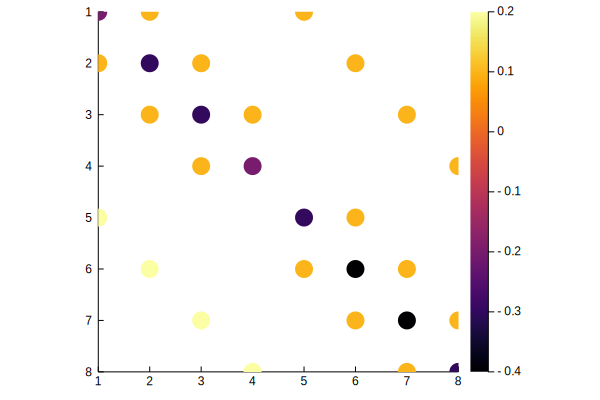

In [39]:
using Plots
spy(L, markersize = 10)

To calculate a simple dynamic pricing problem, consider if the payoff of being in state $ (i,j) $ is $ r_{ij} = i + 2j $

In [40]:
r = [i + 2.0j for i in 1:N, j in 1:M]
r = vec(r)  # vectorize it since stacked in same order

8-element Array{Float64,1}:
 3.0
 4.0
 5.0
 6.0
 5.0
 6.0
 7.0
 8.0

Solving the equation $ \rho v = r + L v $

In [41]:
ρ = 0.05
v = (ρ * I - L) \ r
reshape(v, N, M)

4×2 Array{Float64,2}:
  87.8992   93.6134
  96.1345  101.849 
 106.723   112.437 
 114.958   120.672 

To find the stationary distribution, we find the eigenvalue and choose the eigenvector associated with $ \lambda=0 $ .

In [42]:
L_eig = eigen(Matrix(L'))
@assert norm(L_eig.values[end]) < 1E-10

ϕ = L_eig.vectors[:,end]
ϕ = ϕ / sum(ϕ)

8-element Array{Float64,1}:
 0.16666666666666669
 0.1666666666666665 
 0.16666666666666669
 0.1666666666666668 
 0.08333333333333327
 0.08333333333333344
 0.08333333333333331
 0.0833333333333334 

We can reshape this to be two dimensional if it is helpful for visualization

In [43]:
reshape(ϕ, N, size(A,1))

4×2 Array{Float64,2}:
 0.166667  0.0833333
 0.166667  0.0833333
 0.166667  0.0833333
 0.166667  0.0833333

### Irreducibility

As with the discrete time Markov chains, a key question is whether CTMCs are reducible, i.e. states communicate.  The problem
is isomorphic to determining if the directed graph of the Markov chain is [strongly connected](https://en.wikipedia.org/wiki/Strongly_connected_component).

In [44]:
using LinearAlgebra, LightGraphs
α = 0.1
N = 6
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))
Q_graph = DiGraph(Q)
@show is_strongly_connected(Q_graph);  # i.e. can follow directional edges to get to every state

┌ Info: Recompiling stale cache file C:\Users\jlperla\.julia\compiled\v1.2\LightGraphs\Xm08G.ji for LightGraphs [093fc24a-ae57-5d10-9952-331d41423f4d]
└ @ Base loading.jl:1240


is_strongly_connected(Q_graph) = true


Or as an example of a reducible Markov chain,

In [45]:
Q = [-0.2 0.2 0
    0.2 -0.2 0
    0.2 0.6 -0.2]
Q_graph = DiGraph(Q)
@show is_strongly_connected(Q_graph);

is_strongly_connected(Q_graph) = false


## Banded Matrices

A tridiagonal matrix has 3 non-zero diagonals.  The main diagonal, the first sub-diagonal (i.e. below the main diagonal) and the also the first super-diagonal (i.e. above the main diagonal).

This is a special case of a more general type called a banded matrix, where the number of sub and super-diagonals are more general.  The
total width of sub- and super-diagonals is called the bandwidth.  For example, a tridiagonal matrix has a bandwidth of 3.

A $ N \times N $ banded matrix with bandwidth $ P $ has about $ N P $ nonzeros in its sparsity pattern.

These can be created directly as a dense matrix with `diagm`

In [46]:
diagm(1 => [1,2,3], -1 => [4,5])

4×4 Array{Int64,2}:
 0  1  0  0
 4  0  2  0
 0  5  0  3
 0  0  0  0

Or as a sparse matrix,

In [47]:
spdiagm(1 => [1,2,3], -1 => [4,5])

4×4 SparseMatrixCSC{Int64,Int64} with 5 stored entries:
  [2, 1]  =  4
  [1, 2]  =  1
  [3, 2]  =  5
  [2, 3]  =  2
  [3, 4]  =  3

Creating a simple banded matrix, using [BandedMatrices.jl](https://github.com/JuliaMatrices/BandedMatrices.jl)

In [48]:
using BandedMatrices
BandedMatrix(-1=> 1:5, 2=>1:3)     # creates a 5 x 5 banded matrix version of diagm(-1=> 1:5, 2=>1:3)

6×6 BandedMatrix{Int64,Array{Int64,2},Base.OneTo{Int64}}:
 0  0  1  ⋅  ⋅  ⋅
 1  0  0  2  ⋅  ⋅
 ⋅  2  0  0  3  ⋅
 ⋅  ⋅  3  0  0  0
 ⋅  ⋅  ⋅  4  0  0
 ⋅  ⋅  ⋅  ⋅  5  0

There is also a convenience function for generating random banded matrices

In [49]:
A = brand(7, 7, 3, 1)  # 3 subdiagonals, 1 subdiagonal

7×7 BandedMatrix{Float64,Array{Float64,2},Base.OneTo{Int64}}:
 0.852039  0.909192   ⋅         ⋅         ⋅         ⋅         ⋅       
 0.279266  0.365279  0.231345   ⋅         ⋅         ⋅         ⋅       
 0.109687  0.719595  0.32635   0.374328   ⋅         ⋅         ⋅       
 0.197615  0.441325  0.486003  0.386271  0.770824   ⋅         ⋅       
  ⋅        0.999804  0.438857  0.424792  0.624999  0.177116   ⋅       
  ⋅         ⋅        0.449552  0.754709  0.155209  0.916274  0.0422574
  ⋅         ⋅         ⋅        0.815217  0.41038   0.13815   0.163309 

And, of course, specialized algorithms will be used to exploit the structure when solving linear systems.  In particular, the complexity is related to the $ O(N P_L P_U) $ for upper and lower bandwidths $ P $

In [50]:
A \ rand(7)

7-element Array{Float64,1}:
  1.1696030461238491
 -0.5150413770678577
  1.4940261680075608
  1.9642389792846187
 -0.9650376463803029
 -0.8866876609401638
 -4.879284825844109 

### BlockBanded and BandedBlockBanded

Taking the structured matrix concept further, we can consider examples of matrices in blocks, each of which are banded, and even
a matrix where each block is banded, and the blocks themselves are banded.

This final type is common in the discretization of multiple dimensions with continuous time processes.  For example, with the
example from above of 2 dimensions.

In [51]:
using BandedMatrices, BlockBandedMatrices, LazyArrays, SparseArrays
function markov_chain_product_banded(Q_chains, A)
    M = size(Q_chains[1], 1)
    N = size(A, 1)
    Q_bands = bandwidths(Q_chains[1])

    Qs = blockdiag(sparse.(Q_chains)...)  # create diagonal blocks of every operator
    Qs = BandedBlockBandedMatrix(Qs, (M*ones(Int64, N), M*ones(Int64, N)), (0,0), Q_bands)

    # construct a kronecker product of A times I_M
    As = BandedBlockBandedMatrix(Kron(A, Eye(M)))
    return Qs + As
end

α1 = 0.05
α2 = 0.15
α3 = 0.1
N = 5
symmetric_tridiagonal_chain(α, N) = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))
Q1 = symmetric_tridiagonal_chain(α1, N)
Q2 = symmetric_tridiagonal_chain(α2, N)
Q3 = symmetric_tridiagonal_chain(α3, N)
A = Tridiagonal([0.1, 0.1], [-0.2, -0.3, -0.2], [0.2, 0.2])
M = size(A,1)

L = markov_chain_product_banded((Q1, Q2, Q3), A)

3×3-blocked 15×15 BandedBlockBandedMatrix{Float64,BlockArrays.PseudoBlockArray{Float64,2,Array{Float64,2},BlockArrays.BlockSizes{2,Tuple{Array{Int64,1},Array{Int64,1}}}}}:
 -0.25   0.05    ⋅      ⋅      ⋅    │  …    ⋅      ⋅     ⋅     ⋅     ⋅   │    ⋅ 
  0.05  -0.3    0.05    ⋅      ⋅    │       ⋅      ⋅     ⋅     ⋅     ⋅   │    ⋅ 
   ⋅     0.05  -0.3    0.05    ⋅    │       ⋅      ⋅     ⋅     ⋅     ⋅   │    ⋅ 
   ⋅      ⋅     0.05  -0.3    0.05  │      0.0     ⋅     ⋅     ⋅     ⋅   │    ⋅ 
   ⋅      ⋅      ⋅     0.05  -0.25  │
 ───────────────────────────────────┼      0.2     ⋅     ⋅     ⋅     ⋅   │    ⋅ 
 ───────────────────────────────┼──────
  0.1    0.0     ⋅      ⋅      ⋅    │  …    ⋅     0.2   0.0    ⋅     ⋅   │    ⋅ 
  0.0    0.1    0.0     ⋅      ⋅    │       ⋅     0.0   0.2   0.0    ⋅   │    ⋅ 
   ⋅     0.0    0.1    0.0     ⋅    │       ⋅      ⋅    0.0   0.2   0.0  │    ⋅ 
   ⋅      ⋅     0.0    0.1    0.0   │      0.15    ⋅     ⋅    0.0   0.2  │   0.0
   ⋅      ⋅      ⋅   

As before, define a payoff function

In [52]:
r = vec([i + 2.0j for i in 1:N, j in 1:M])

15-element Array{Float64,1}:
  3.0
  4.0
  5.0
  6.0
  7.0
  5.0
  6.0
  7.0
  8.0
  9.0
  7.0
  8.0
  9.0
 10.0
 11.0

Solving the equation $ \rho v = r + L v $

In [53]:
ρ = 0.05
v = (ρ * I - L) \ r
reshape(v, N, M)

5×3 Array{Float64,2}:
  69.7187   70.1489  58.1218
  77.7164   76.5214  63.2774
  88.2105   85.2632  70.1053
  98.7046   94.0049  76.9331
 106.702   100.377   82.0887

Or to find the stationary solution,

In [54]:
using Arpack
L = sparse(L')
λ, ϕ = eigs(L, nev=1, which=:SM)
ϕ = real(ϕ) ./ sum(real(ϕ))
reshape(ϕ, N, M)

5×3 Array{Float64,2}:
 0.0438447  0.0684658  0.0876894
 0.0438447  0.0684658  0.0876894
 0.0438447  0.0684658  0.0876894
 0.0438447  0.0684658  0.0876894
 0.0438447  0.0684658  0.0876894


<a id='implementation-numerics'></a>

## Implementing Low Level Kernels

Recall the famous quote from Knuth: “Premature optimization is the root of all evil. Yet we should not pass up our opportunities in that critical 3%”.  The most common example of premature optimization is trying to use your own mental model of a compiler while writing your code, overly worried about the efficiency of code and (usually incorrectly) second-guessing the compiler.

Concretely, the lessons in this section are

1. Don’t worry about optimizing your code unless you need to.  Code clarity is your first-order concern.  
1. If you use other people’s packages, they can worry about performance and you don’t need to.  
1. If you absolutely need that “critical 3%” your intuition about performance is usually wrong on modern CPUs and GPUs, so let the compiler do its job..  
1. Benchmarking (e.g. `@btime`) and [profiling](https://docs.julialang.org/en/v1/manual/profile/) are the tools to figure out performance bottlenecks  
1. If you benchmark to show that a particular part of the code is an issue, and you can’t find another library that does a better job, then you can worry about performance.  


You will rarely get to step 3 let alone step 5.

However, there is also a corollary:  “don’t pessimize prematurely”. That is, don’t make choices that lead to poor performance without any tradeoff in improved code clarity.  For example, writing your own algorithms when a high performance algorithm exists in a package or Julia itself.

### Implementation Difficulty

Numerical analysis tend to refer to the lowest level of code for basic operations (e.g. a dot product, matrix-matrix product, convolutions) as `kernels`.

That sort of code is difficult to write, and performance depends on the characteristics of the underlying hardware such as the [instruction set](https://en.wikipedia.org/wiki/Instruction_set_architecture) available on the particular CPU, the size of the [CPU cache](https://en.wikipedia.org/wiki/CPU_cache), the layout of arrays in memory, and a number of other things.

Typically these operations are written in a [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) library, organized into level.  The levels roughly correspond to the order of the opertions:  BLAS Level 1 are $ O(N) $ operations such as linear products, Level 2 are $ O(N^2) $ operations such as matrix-vector products, and Level 3 are $ O(N^3) $ such as matrix-matrix products.

An example of a BLAS library is the [Intel MKL](https://en.wikipedia.org/wiki/Math_Kernel_Library) used in Matlab and Julia (if an additional package is installed.

On top of BLAS are [LAPACK](https://en.wikipedia.org/wiki/LAPACK) operations, which are higher level kernels, such as Matrix factorizations and eigenvalue algorithms, and are often in the same libraries (e.g. MKL).

The details of all of these are irrelevant, but if you are talking to people about performance, they will inevitably through out all of these concepts.  There are a few important lessons to keep in mind:

- Leave writing kernels to the experts.  Even simple sounding algorithms can be very complicated to make high performance.  
- Your intuition about performance of code is probably going to be wrong.  If you use high quality libraries, you don’t need to use your intuition.  
- Don’t get distracted by the jargon or acronyms above if you are reading about performance.  

### Row and Column-Major Ordering

Finally, there is one practical issue which may influence your code.  Since memory in a CPU is linear, dense matrices need to be stored by either stacking columns (called column-major order <https://en.wikipedia.org/wiki/Row-_and_column-major_order>) or by columns (called row-major order).

The reason this matters is that compilers can generate better performance if they work in contiguous chunks of memory rather than jumping around, and this becomes especially important with large matrices due to the interaction with the CPU cache.  Choosing the wrong order when there is no benefit in code clarity is a classic example of premature pessimization.  The performance difference can be orders of magnitude in some cases, and nothing in other cases.

One option is to use the functions that let the compiler choose the most efficient way to traverse memory. If you need to choose the looping order yourself, then you might want to experiment with swapping whether you go through columns or rows first.  Other times, let Julia decide, i.e. `enumerate` and `eachindex` will choose the right approach

Julia, Fortran, and Matlab all use column-major order while C/C++ and Python use row-major order.  This means that if you find an algorithm written for C/C++/Python you will sometimes need to make small changes if performance is an issue.

## Exercises

### Exercise 1

This exercise is for a little practice on low-level routines, and to hopefully convince you to leave low-level code to the experts.

The formula for matrix multiplication is deceptively simple.  For example, with the product of square matrices $ C = A B $ of size $ N \times N $, the $ i,j $ element of $ C $ is

$$
C_{ij} = \sum_{k=1}^N A_{ik} B_{kj}
$$

Alternatively, you can take a row $ A_{i,:} $ and column $ B_{:, j} $ and use an inner product

$$
C_{ij} = A_{i,:} \cdot B_{:,j}
$$

Note that the inner product in a discrete space is simply a sum, and has the same complexity (i.e. $ O(N) $ operations).

For a dense matrix without any structure, this also makes it clear why the complexity is $ O(N^3) $: you need to evaluate it for $ N^2 $ elements in the matrix and do an $ O(N) $ operation each time.

For this exercise, implement matrix multiplication yourself and compare performance in a few permutations.

1. Use the built-in function in Julia (i.e.``C = A * B`` or, for a better comparison, the inplace version `mul!(C, A, B)` which works with preallocated data)  
1. Loop over each $ C_{ij} $ by the row first (i.e. the `i` index) and use a `for` loop for the inner product  
1. Loop over each $ C_{ij} $ by the column first (i.e. the `j` index) and use a `for` loop for the inner product  
1. Do the same but use the `dot` product instead of the sum.  
1. Choose your best implementation of these, and then for matrices of a few different sizes `N=10`, `N=1000`, etc. and compare the ratio of performance of your best implementation to the one built into Julia (actually, the BLAS library above).  


A few more hints:

- You can just use random matrices, e.g. `A = rand(N, N)`, etc.  
- For all of them, preallocate the $ C $ matrix beforehand with `C = similar(A)` or something equivalent.  
- To compare performance, put your code in a function and use `@btime` macro to time it.  Remember to escape globals if necessary (e.g. `@btime f(\$A)` rather than `@btime f(A)`  

### Exercise 2a

Here we will calculate the evolution of a discrete time Markov Chain starting from :math:`phi_0`.

Start with a simple symmetric tridiagonal matrix

In [55]:
N = 100
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2)])
A_adjoint = A'

100×100 Tridiagonal{Float64,Array{Float64,1}}:
 0.8  0.1   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
 0.2  0.8  0.1   ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   0.1  0.8  0.1   ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   0.1  0.8  0.1   ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   0.1  0.8  0.1   ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   0.1  0.8  0.1   ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   0.1  0.8  0.1      ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   0.1  0.8      ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   0.1      ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    

1. Pick some large `T` and start with $ \phi_0 = \begin{bmatrix} 1 & 0 & \ldots & 0\end{bmatrix} $  
1. Write code to calculate $ \phi_t $ to some `T` by iterating the map for each `t`, i.e.  


$$
\phi_{t+1} = A' \phi_t
$$

1. What is the computational order of that calculating  $ \phi_T $ using this iteration approach $ T < N $?  
1. What is the computational order of $ (A')^T = (A \ldots A) $ and then $ \phi_T = (A')^T \phi_0 $ for $ T < N $?  
1. Benchmark calculating $ \phi_T $ with the iterative calculation above as well as the direct $ \phi_T = (A')^T \phi_0 $ to see which is faster.  You can take the matrix power with just `A_adjoint^T`, uses specialized algorithms faster and more accurate than repeated matrix multiplication (but with the same computational order).  
1. Check the same if $ T = 2 N $  


Note: The algorithm used in Julia to take matrix powers  depends on the matrix structure, as usual.  In the symmetric case, it can use an eigendecomposition, whereas with a general dense matrix it uses [squaring and scaling](https://doi.org/10.1137/090768539).

### Exercise 2b

With the same setup as Exercise 2a, do an [eigen decomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) of `A_transpose`.  That is, use `eigen` to do a factorization of the adjoint $ A' = Q \Lambda Q^{-1} $ where $ Q $ the matrix of eigenvectors and $ \Lambda $ the diagonal matrix of eigenvalues.  Calculate $ Q^{-1} $ as well.

> Use the factored matrix to calculate the sequence of $ \phi_t = (A')^t \phi_0 $ using the relationship


$$
\phi_t = Q \Lambda^t Q^{-1} \phi_0
$$

Where matrix powers of diagonal matrices are simply the elementwise power of each element.

Benchmark the speed of calculating the sequence of $ \phi_t $ up to `T = 2N` using this method.  In principle, the factorization and easy calculation of the power should give you benefits.  Explain why it does or does not using computational order.